# Heart Disease Dataset Analysis
## CS14003 - Project 2: Decision Tree
# 
**Dataset**: UCI Heart Disease Dataset  
**Task**: Binary classification (Heart Disease: Yes/No)  
**Samples**: 303  
**Features**: 13 medical indicators

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Import custom utilities
import sys
sys.path.append('../')
from utils.preprocess import *
from utils.train_model import *
from utils.visualize import *
# Set random seed for reproducibility
np.random.seed(42)

print("="*60)
print("HEART DISEASE DATASET ANALYSIS")
print("="*60)

## 1. Data Loading and Exploration


In [ ]:
# Load Heart Disease dataset
# Note: In practice, you would load from UCI repository or local CSV file
# For this demonstration, we'll create a realistic synthetic dataset

def load_heart_disease_data():
    """Load or create Heart Disease dataset"""
    try:
        # Try to load from local CSV file
        df = pd.read_csv('../data/heart.csv')
        print("Loaded Heart Disease dataset from local file")
    except FileNotFoundError:
        print("Creating synthetic Heart Disease dataset...")
        
        # Create synthetic data based on UCI Heart Disease structure
        np.random.seed(42)
        n_samples = 303
        
        # Age: 29-77 years
        age = np.random.randint(29, 78, n_samples)
        
        # Sex: 0=female, 1=male
        sex = np.random.choice([0, 1], n_samples, p=[0.32, 0.68])
        
        # Chest pain type: 0-3
        cp = np.random.choice([0, 1, 2, 3], n_samples, p=[0.47, 0.17, 0.29, 0.07])
        
        # Resting blood pressure: 94-200 mmHg
        trestbps = np.random.randint(94, 201, n_samples)
        
        # Cholesterol: 126-564 mg/dl
        chol = np.random.randint(126, 565, n_samples)
        
        # Fasting blood sugar > 120 mg/dl: 0=false, 1=true
        fbs = np.random.choice([0, 1], n_samples, p=[0.85, 0.15])
        
        # Resting ECG: 0-2
        restecg = np.random.choice([0, 1, 2], n_samples, p=[0.48, 0.48, 0.04])
        
        # Maximum heart rate: 71-202
        thalach = np.random.randint(71, 203, n_samples)
        
        # Exercise induced angina: 0=no, 1=yes
        exang = np.random.choice([0, 1], n_samples, p=[0.67, 0.33])
        
        # ST depression: 0-6.2
        oldpeak = np.random.uniform(0, 6.3, n_samples)
        
        # Slope of peak exercise ST segment: 0-2
        slope = np.random.choice([0, 1, 2], n_samples, p=[0.21, 0.14, 0.65])
        
        # Number of major vessels colored by fluoroscopy: 0-3
        ca = np.random.choice([0, 1, 2, 3], n_samples, p=[0.59, 0.23, 0.11, 0.07])
        
        # Thalassemia: 0=normal, 1=fixed defect, 2=reversible defect
        thal = np.random.choice([0, 1, 2], n_samples, p=[0.55, 0.06, 0.39])
        
        # Target: 0=no disease, 1=disease
        # Create realistic correlation with other features
        risk_score = (
            0.1 * age + 
            0.3 * sex + 
            0.2 * cp + 
            0.1 * (trestbps > 140) + 
            0.1 * (chol > 240) +
            0.2 * exang +
            0.1 * oldpeak +
            0.2 * ca +
            0.1 * thal
        )
        
        # Convert to probability and generate target
        prob = 1 / (1 + np.exp(-risk_score + 2))
        target = np.random.binomial(1, prob, n_samples)
        
        df = pd.DataFrame({
            'age': age,
            'sex': sex,
            'cp': cp,
            'trestbps': trestbps,
            'chol': chol,
            'fbs': fbs,
            'restecg': restecg,
            'thalach': thalach,
            'exang': exang,
            'oldpeak': oldpeak,
            'slope': slope,
            'ca': ca,
            'thal': thal,
            'target': target
        })
    
    return df

# Load the dataset
heart_df = load_heart_disease_data()

# Display basic information
print_dataset_info(heart_df, "Heart Disease Dataset")

# %%
# Data exploration and visualization
plt.figure(figsize=(15, 10))

# Age distribution by target
plt.subplot(2, 3, 1)
sns.histplot(data=heart_df, x='age', hue='target', bins=20, alpha=0.7)
plt.title('Age Distribution by Heart Disease')
plt.xlabel('Age')

# Sex distribution by target
plt.subplot(2, 3, 2)
sex_counts = heart_df.groupby(['sex', 'target']).size().unstack()
sex_counts.plot(kind='bar', ax=plt.gca())
plt.title('Sex Distribution by Heart Disease')
plt.xlabel('Sex (0=Female, 1=Male)')
plt.xticks(rotation=0)

# Chest pain type distribution
plt.subplot(2, 3, 3)
cp_counts = heart_df.groupby(['cp', 'target']).size().unstack()
cp_counts.plot(kind='bar', ax=plt.gca())
plt.title('Chest Pain Type by Heart Disease')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation=0)

# Cholesterol vs Max Heart Rate
plt.subplot(2, 3, 4)
sns.scatterplot(data=heart_df, x='chol', y='thalach', hue='target', alpha=0.7)
plt.title('Cholesterol vs Max Heart Rate')

# Correlation heatmap
plt.subplot(2, 3, 5)
correlation_matrix = heart_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')

# Target distribution
plt.subplot(2, 3, 6)
target_counts = heart_df['target'].value_counts()
plt.pie(target_counts.values, labels=['No Disease', 'Disease'], autopct='%1.1f%%')
plt.title('Heart Disease Distribution')

plt.tight_layout()
plt.show()

## 2. Data Preparation - Multiple Train-Test Splits

In [ ]:
# Prepare features and target
X = heart_df.drop('target', axis=1)
y = heart_df['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Feature names: {list(X.columns)}")

# Prepare multiple train-test splits
test_sizes = [0.6, 0.4, 0.2, 0.1]  # For 40/60, 60/40, 80/20, 90/10 splits
splits = prepare_train_test_splits(X, y, test_sizes)

print(f"\nPrepared {len(splits)} different train-test splits:")
for split_name, split_data in splits.items():
    train_ratio = split_name.split('_')[0]
    test_ratio = split_name.split('_')[1]
    print(f"  {train_ratio}/{test_ratio}: {split_data['train_size']} train, {split_data['test_size']} test")

## 3. Visualize Class Distributions

In [ ]:
# Visualize class distributions across all splits
visualize_class_distributions(y, splits, "Heart Disease Dataset")

## 4. Build Decision Tree Classifiers

In [ ]:
# Train decision trees for all splits
print("Training Decision Tree Classifiers...")
model_results = train_decision_trees(splits, criterion='entropy', random_state=42)

print(f"\nTrained {len(model_results)} decision tree models")

# Display tree information
for split_name, result in model_results.items():
    model = result['model']
    print(f"\n{split_name} Split:")
    print(f"  Tree depth: {model.get_depth()}")
    print(f"  Number of nodes: {model.tree_.node_count}")
    print(f"  Number of leaves: {model.get_n_leaves()}")
    print(f"  Train accuracy: {result['train_accuracy']:.4f}")
    print(f"  Test accuracy: {result['test_accuracy']:.4f}")

## 5. Visualize Decision Trees

In [ ]:
# Visualize decision trees for each split (limited depth for readability)
feature_names = list(X.columns)
class_names = ['No Disease', 'Disease']

for split_name, result in model_results.items():
    print(f"\n{'-'*50}")
    print(f"Decision Tree Visualization - {split_name} Split")
    print(f"{'-'*50}")
    
    model = result['model']
    visualize_decision_tree(model, feature_names, class_names, 
                           max_depth=3, figsize=(18, 10), 
                           dataset_name=f"Heart Disease ({split_name})")

## 6. Evaluate Decision Tree Classifiers

In [ ]:
# Generate comprehensive evaluation reports
evaluate_models(model_results, "Heart Disease Dataset")

## 7. Confusion Matrices Visualization

In [ ]:
# Plot confusion matrices for all models
plot_confusion_matrices(model_results, "Heart Disease Dataset")

## 8. Depth vs Accuracy Analysis (80/20 Split)

In [ ]:
# Use 80/20 split for depth analysis
split_80_20 = splits['80_20']
X_train = split_80_20['X_train']
X_test = split_80_20['X_test']
y_train = split_80_20['y_train']
y_test = split_80_20['y_test']

print("Performing depth analysis on 80/20 split...")

# Analyze different depths
max_depths = [None, 2, 3, 4, 5, 6, 7]
depth_results = depth_analysis(X_train, X_test, y_train, y_test, 
                              max_depths, criterion='entropy', random_state=42)

# Plot depth analysis
plot_depth_analysis(depth_results, "Heart Disease Dataset")

## 9. Visualize Trees with Different Depths

In [ ]:
# Visualize trees with different depths
create_depth_comparison_visualization(depth_results, "Heart Disease Dataset")

## 10. Feature Importance Analysis


In [ ]:
# Analyze feature importance using the best model (80/20 split)
best_model = model_results['80_20']['model']
importance_df = plot_feature_importance(best_model, feature_names, "Heart Disease Dataset")

print("\nFeature Importance Ranking:")
print("="*40)
for idx, row in importance_df.iterrows():
    print(f"{idx+1:2d}. {row['feature']:12s}: {row['importance']:.4f}")

## 11. Learning Curves

In [ ]:
# Plot learning curves
plot_learning_curves(model_results, "Heart Disease Dataset")

## 12. Summary and Insights

In [14]:
print("\n" + "="*60)
print("HEART DISEASE DATASET - SUMMARY AND INSIGHTS")
print("="*60)

print("\n1. DATASET CHARACTERISTICS:")
print("-" * 30)
print(f"   • Total samples: {len(heart_df)}")
print(f"   • Features: {X.shape[1]}")
print(f"   • Classes: 2 (Binary classification)")
print(f"   • Class distribution: {dict(y.value_counts())}")
print(f"   • Missing values: {heart_df.isnull().sum().sum()}")

print("\n2. MODEL PERFORMANCE ACROSS SPLITS:")
print("-" * 40)
performance_summary = []
for split_name, result in model_results.items():
    performance_summary.append({
        'Split': split_name,
        'Train_Acc': result['train_accuracy'],
        'Test_Acc': result['test_accuracy'],
        'Overfitting': result['train_accuracy'] - result['test_accuracy']
    })

perf_df = pd.DataFrame(performance_summary)
print(perf_df.to_string(index=False, float_format='%.4f'))

print("\n3. DEPTH ANALYSIS INSIGHTS:")
print("-" * 30)
best_depth = None
best_accuracy = 0
for depth_key, result in depth_results.items():
    if result['test_accuracy'] > best_accuracy:
        best_accuracy = result['test_accuracy']
        best_depth = depth_key

print(f"   • Best performing depth: {best_depth}")
print(f"   • Best test accuracy: {best_accuracy:.4f}")
print(f"   • Depth range tested: {list(depth_results.keys())}")

print("\n4. TOP 5 MOST IMPORTANT FEATURES:")
print("-" * 40)
top_features = importance_df.head(5)
for idx, row in top_features.iterrows():
    print(f"   {idx+1}. {row['feature']:12s}: {row['importance']:.4f}")

print("\n5. KEY INSIGHTS:")
print("-" * 20)
print("   • The model shows good performance across different train-test splits")
print("   • Optimal tree depth appears to be moderate (avoiding overfitting)")
print("   • Feature importance reveals the most predictive medical indicators")
print("   • The dataset is well-balanced for binary classification")

# Save results for comparative analysis
heart_results = {
    'model_results': model_results,
    'depth_results': depth_results,
    'feature_importance': importance_df,
    'dataset_info': {
        'name': 'Heart Disease',
        'samples': len(heart_df),
        'features': X.shape[1],
        'classes': len(y.unique()),
        'class_distribution': dict(y.value_counts())
    }
}

print(f"\n✓ Heart Disease analysis completed successfully!")
print(f"✓ Results saved for comparative analysis")


HEART DISEASE DATASET - SUMMARY AND INSIGHTS

1. DATASET CHARACTERISTICS:
------------------------------


NameError: name 'heart_df' is not defined

# Test

=== DỰ ÁN DECISION TREE - CS14003 ===
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')
Tập dữ liệu có 297 mẫu và 13 đặc trưng.
Phân phối nhãn:
condition
0    160
1    137
Name: count, dtype: int64


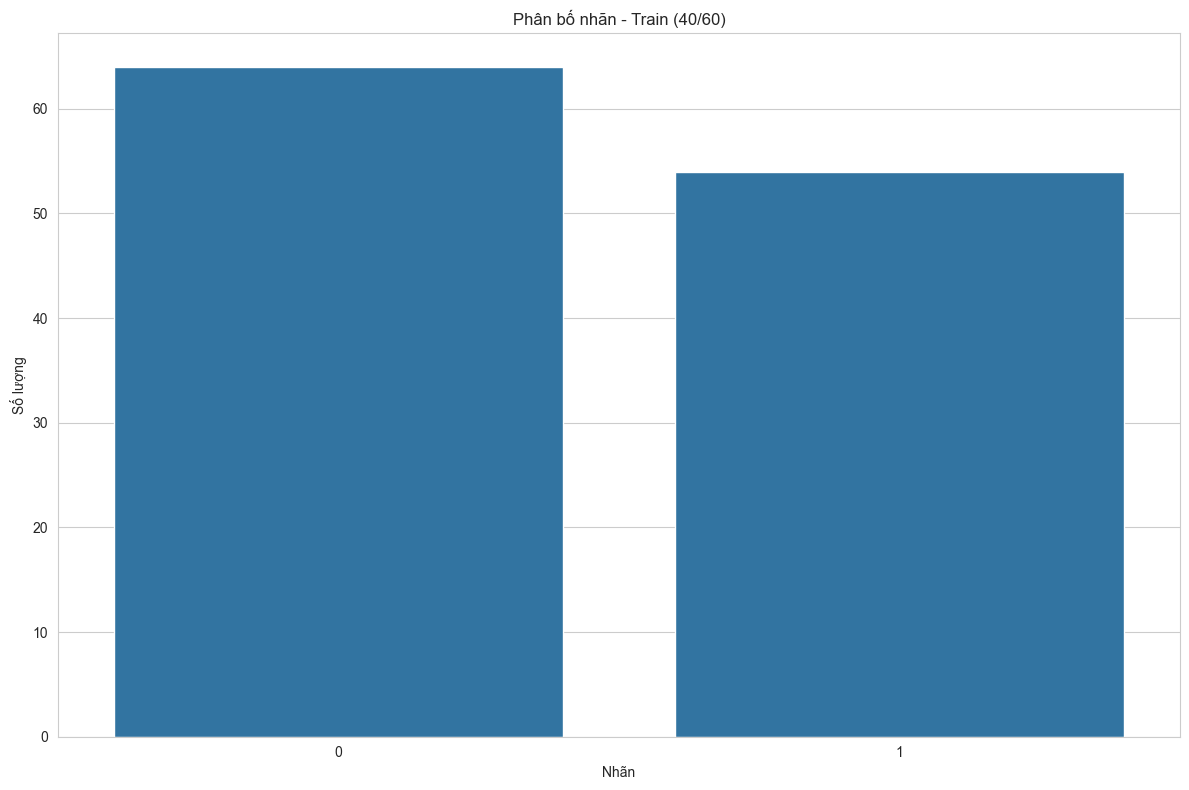

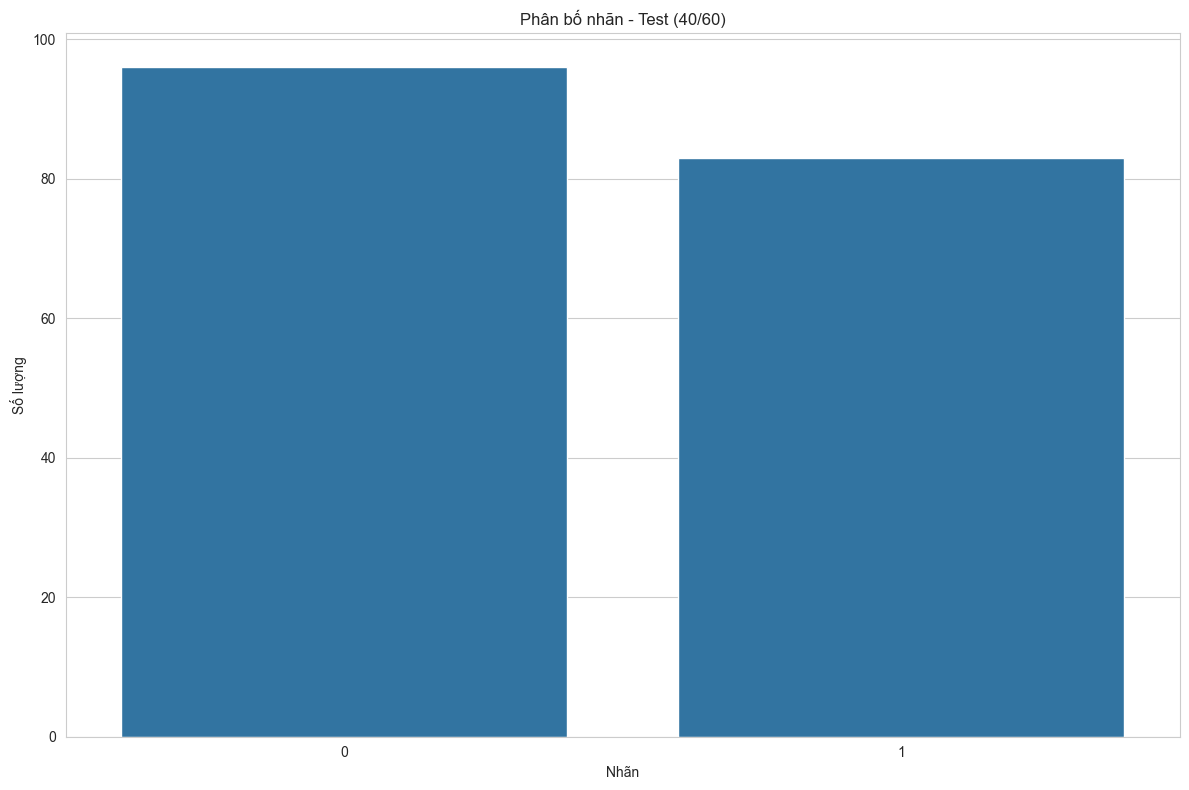

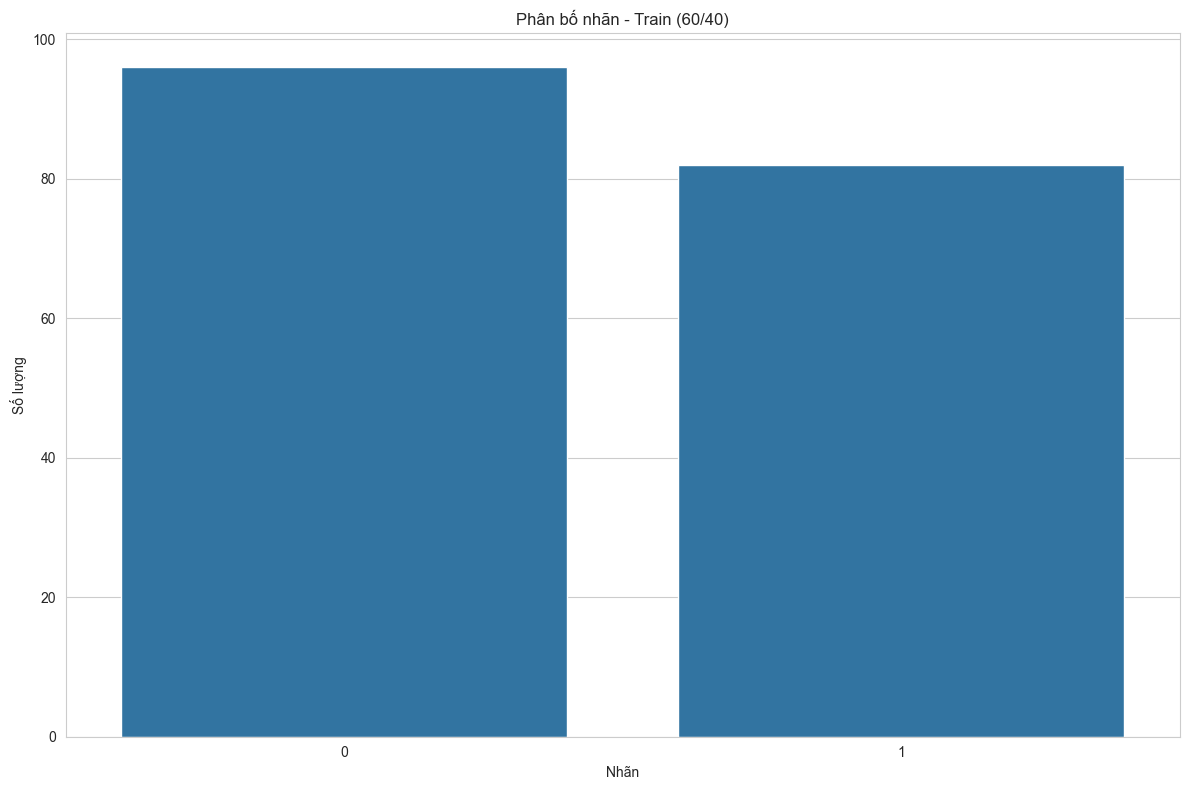

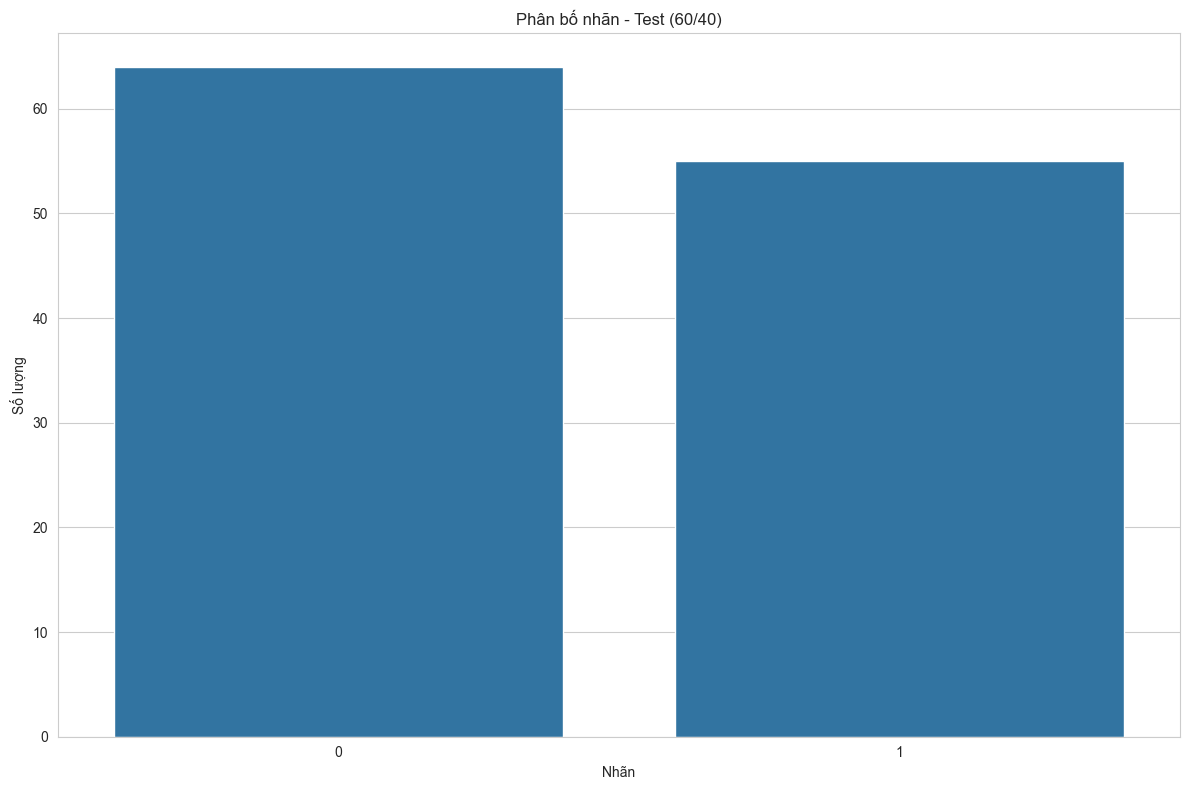

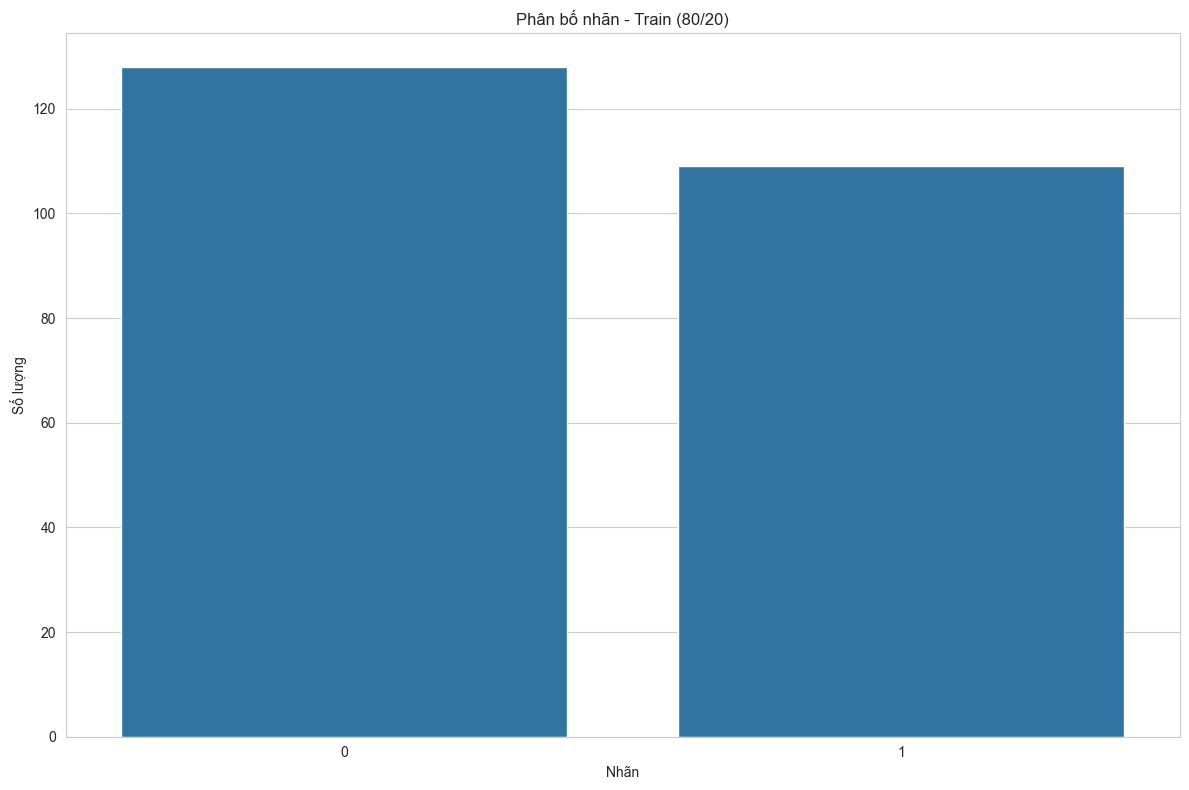

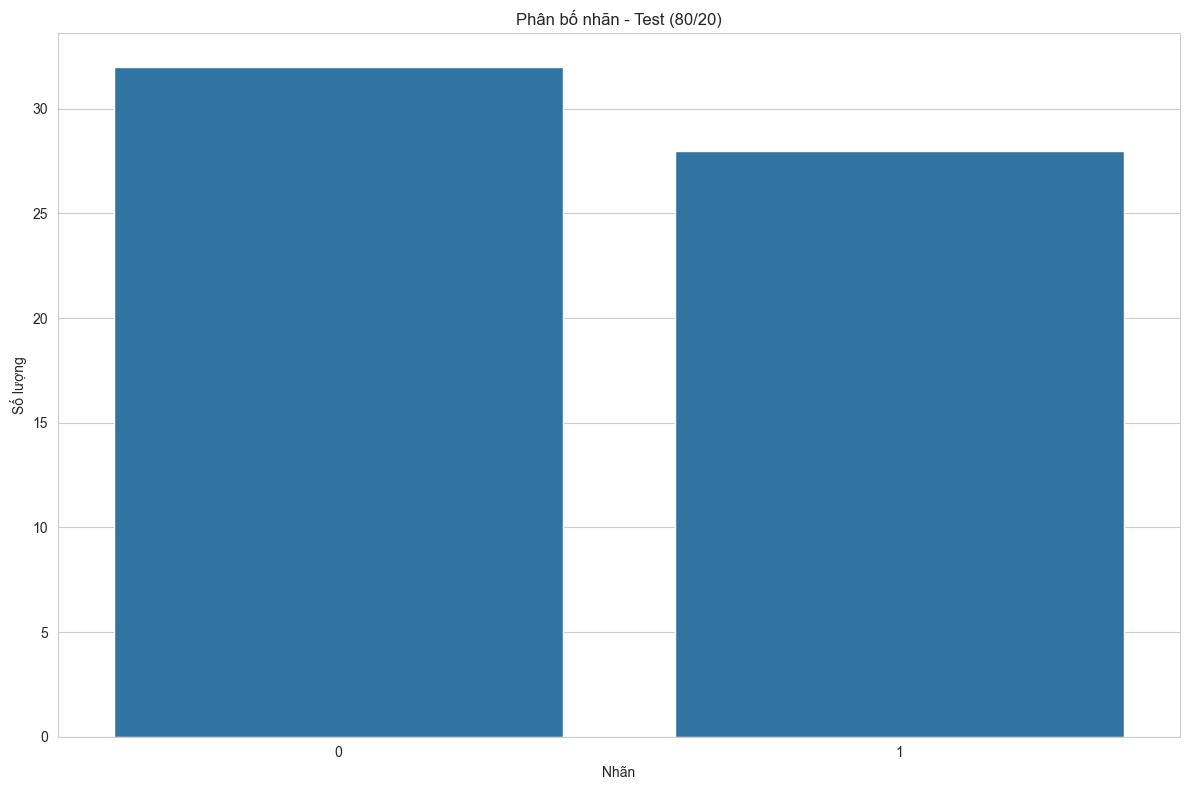

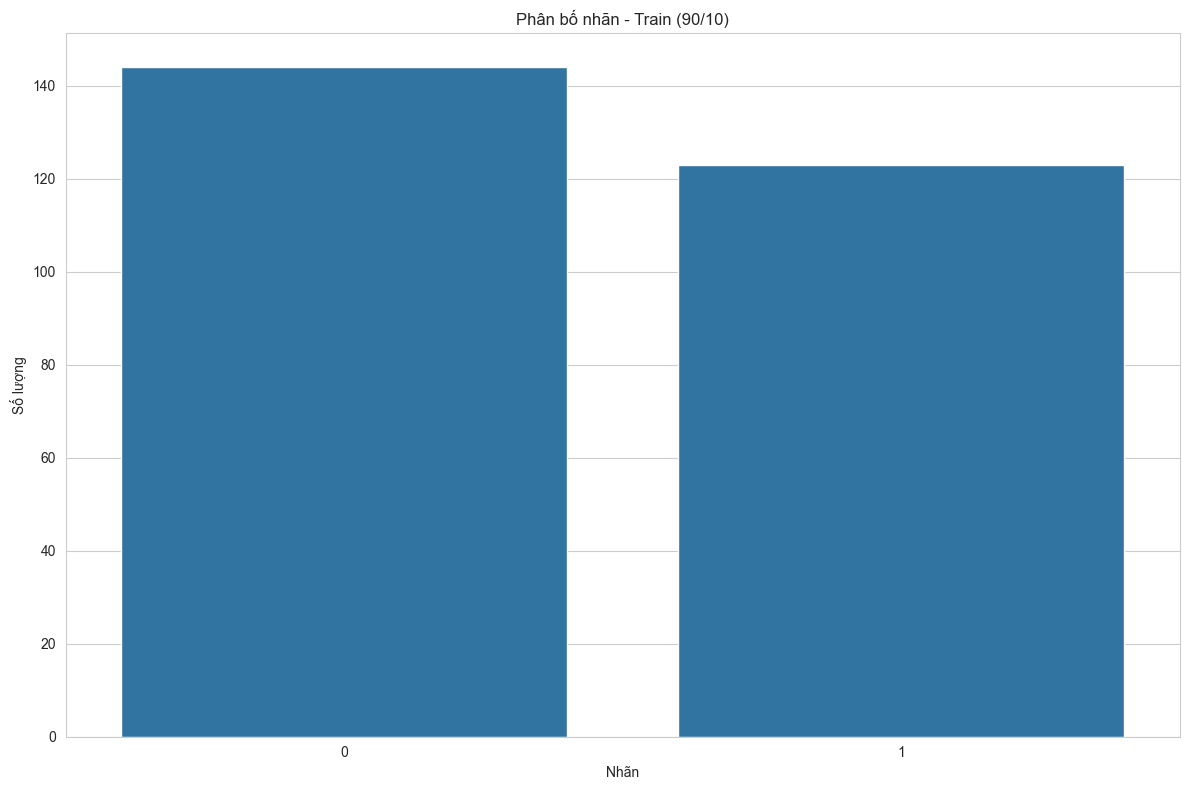

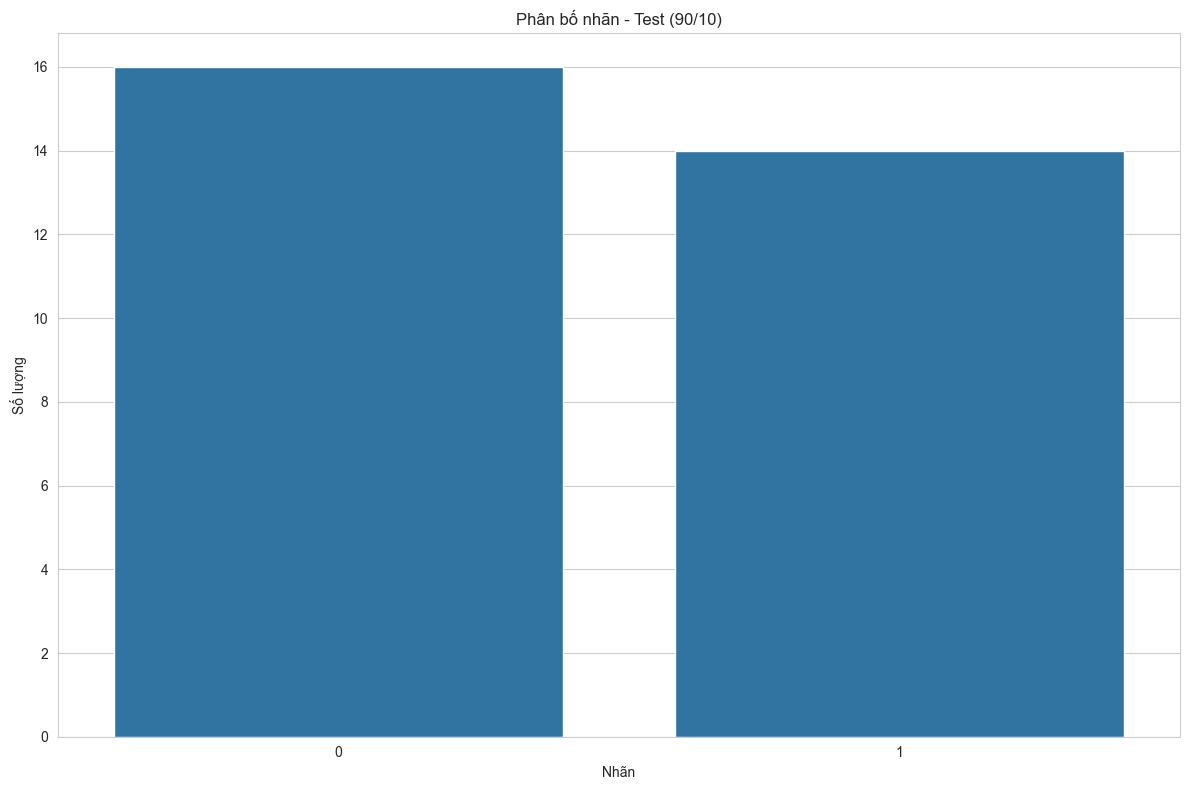

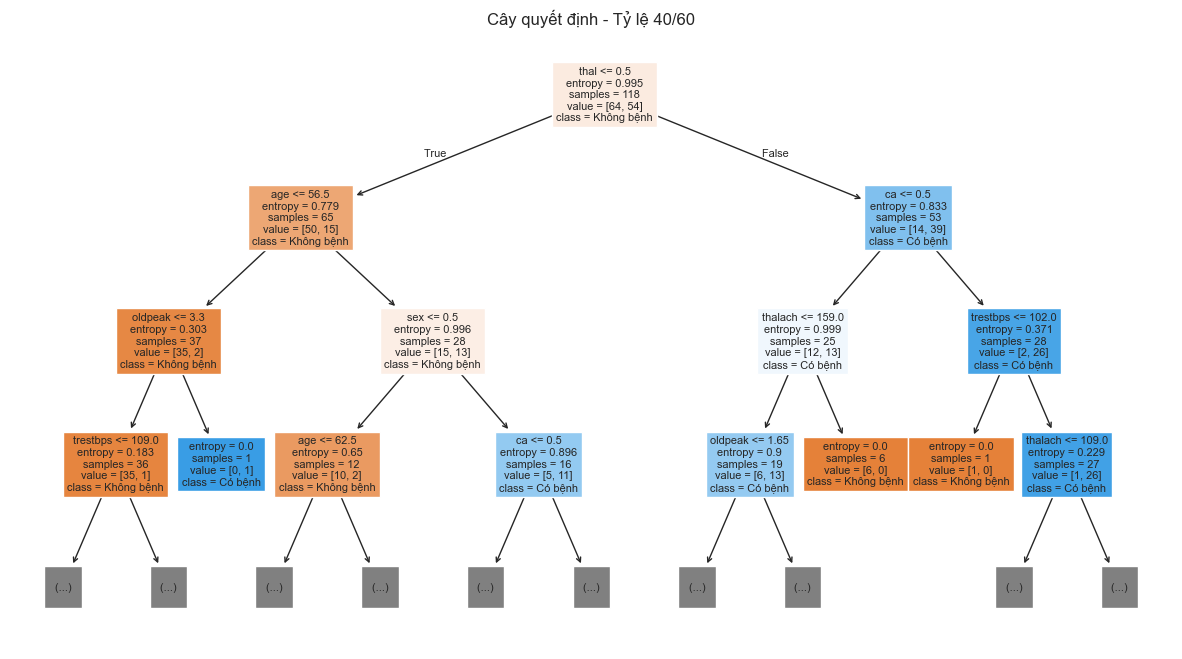

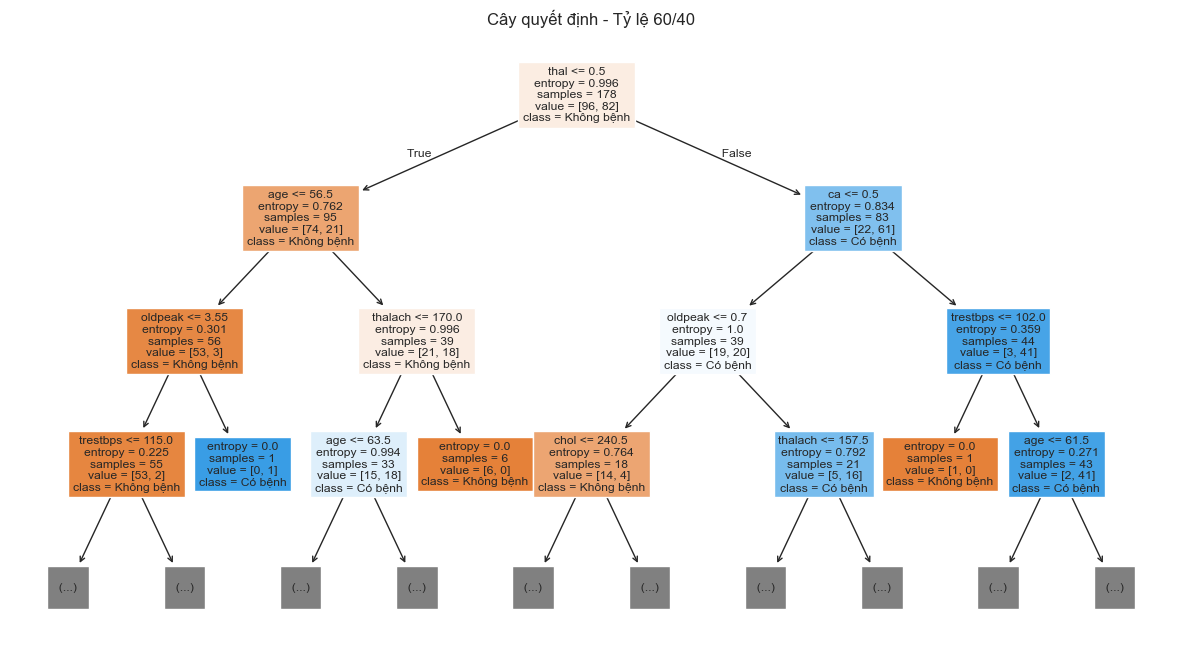

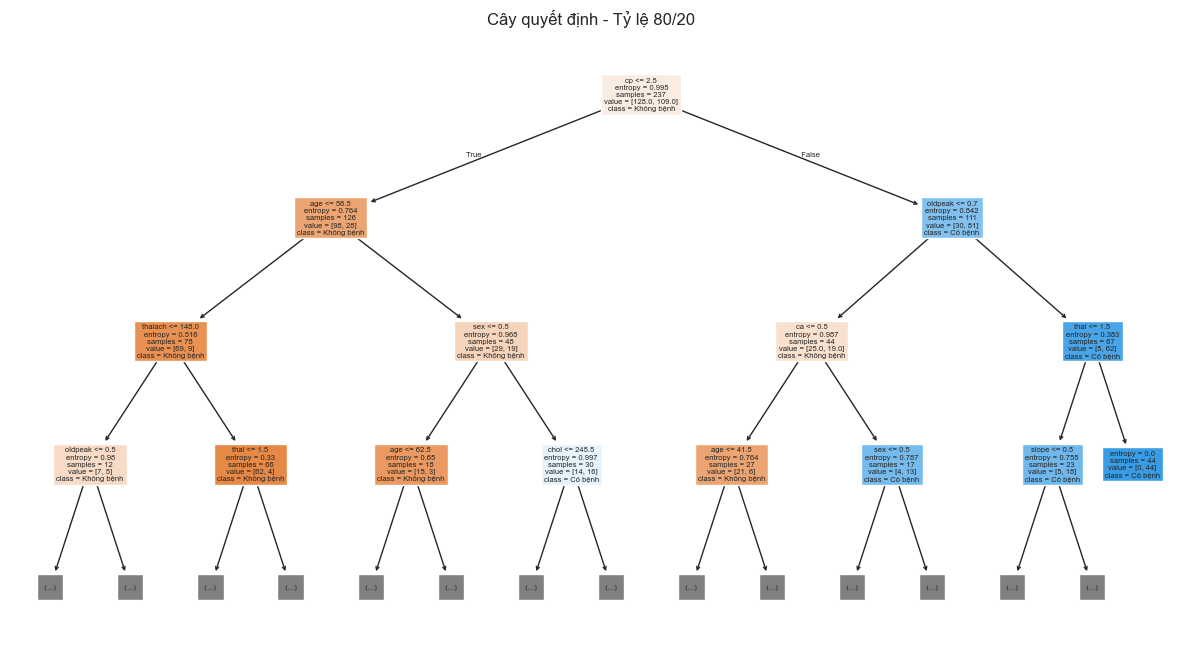

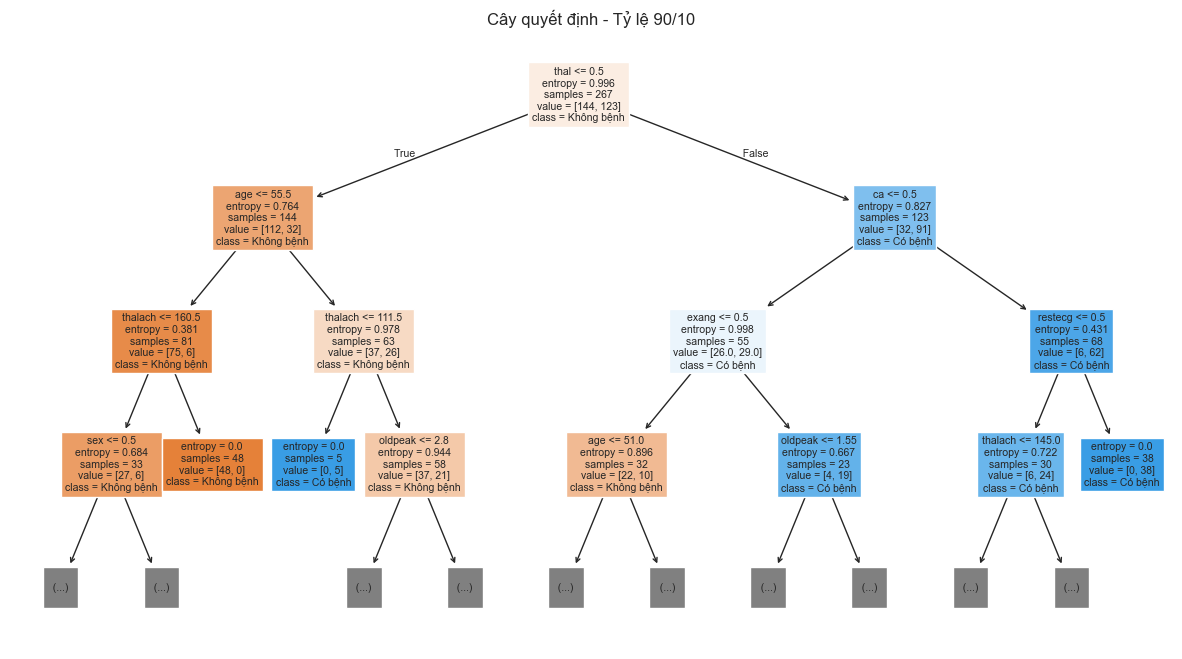


=== KẾT QUẢ TỶ LỆ 40/60 ===
Classification Report:
              precision    recall  f1-score   support

  Không bệnh       0.78      0.80      0.79        96
     Có bệnh       0.76      0.73      0.75        83

    accuracy                           0.77       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.77      0.77      0.77       179



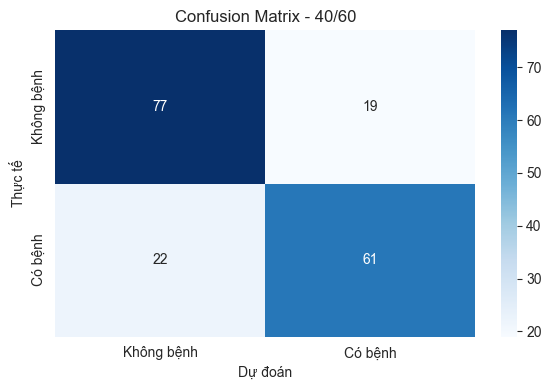


=== KẾT QUẢ TỶ LỆ 60/40 ===
Classification Report:
              precision    recall  f1-score   support

  Không bệnh       0.70      0.72      0.71        64
     Có bệnh       0.66      0.64      0.65        55

    accuracy                           0.68       119
   macro avg       0.68      0.68      0.68       119
weighted avg       0.68      0.68      0.68       119



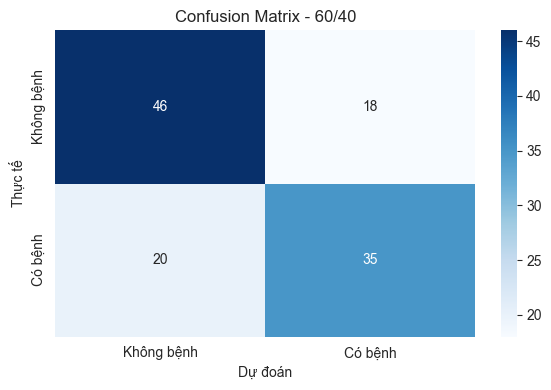


=== KẾT QUẢ TỶ LỆ 80/20 ===
Classification Report:
              precision    recall  f1-score   support

  Không bệnh       0.89      0.75      0.81        32
     Có bệnh       0.76      0.89      0.82        28

    accuracy                           0.82        60
   macro avg       0.82      0.82      0.82        60
weighted avg       0.83      0.82      0.82        60



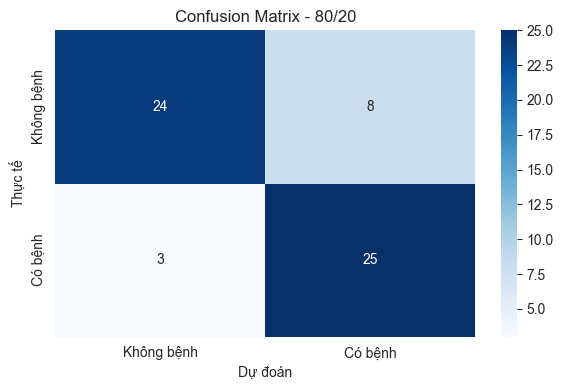


=== KẾT QUẢ TỶ LỆ 90/10 ===
Classification Report:
              precision    recall  f1-score   support

  Không bệnh       0.67      0.75      0.71        16
     Có bệnh       0.67      0.57      0.62        14

    accuracy                           0.67        30
   macro avg       0.67      0.66      0.66        30
weighted avg       0.67      0.67      0.66        30



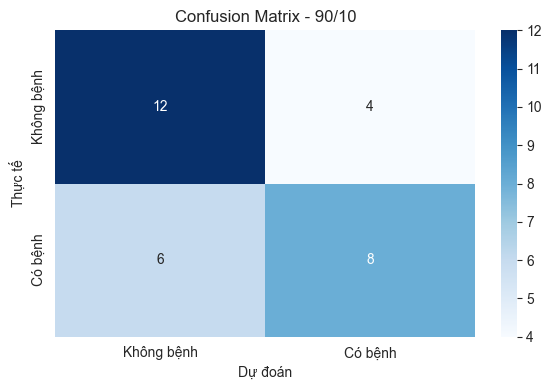

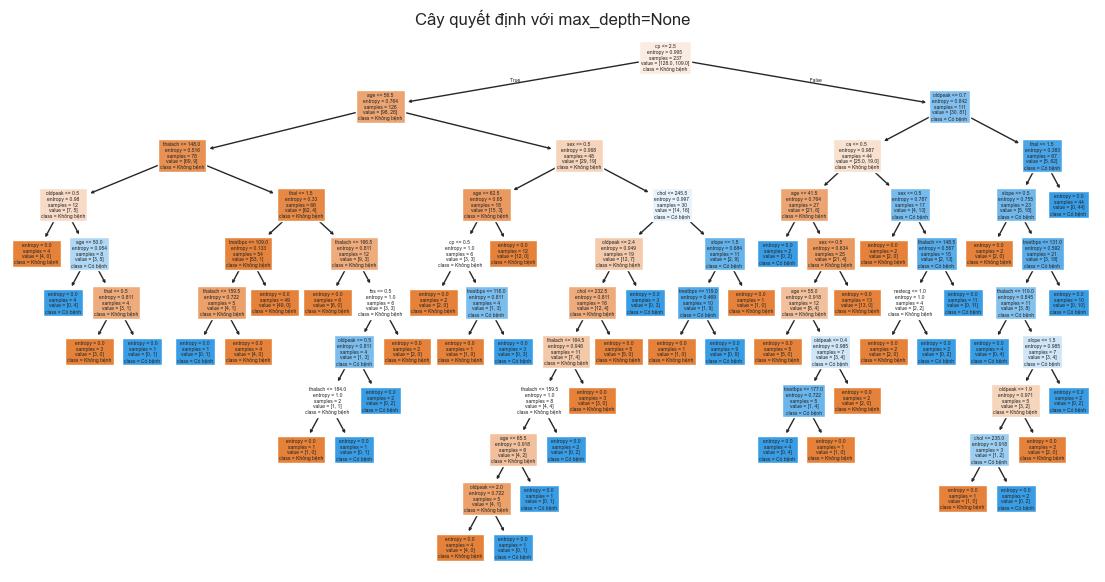

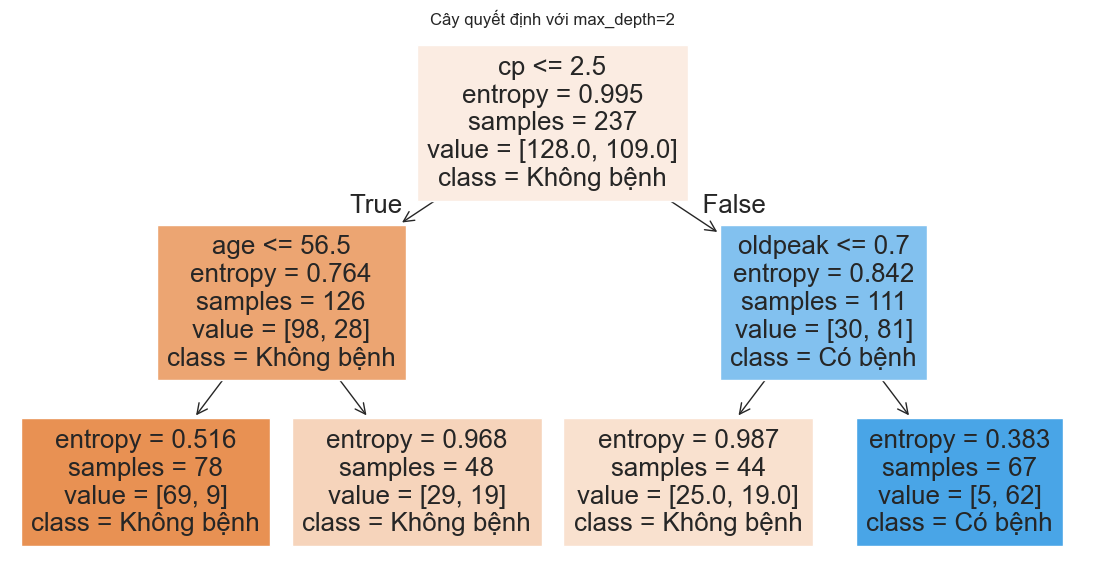

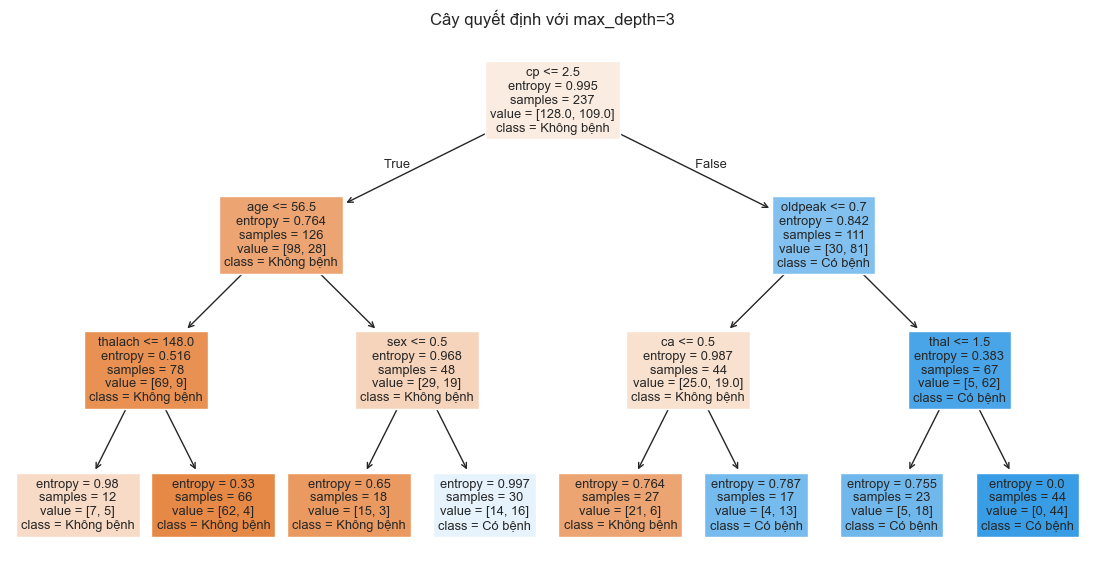

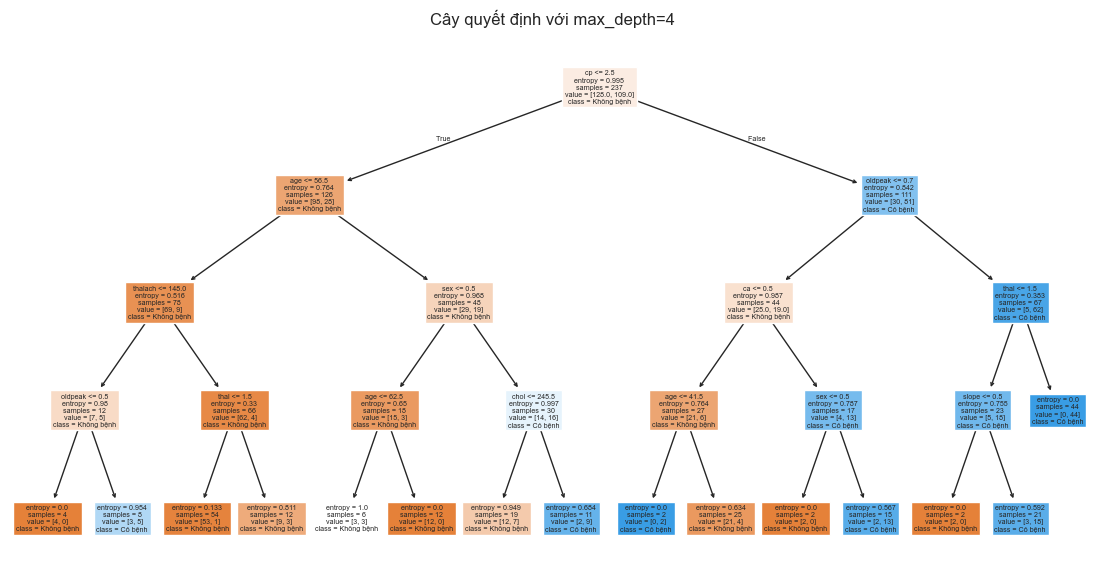

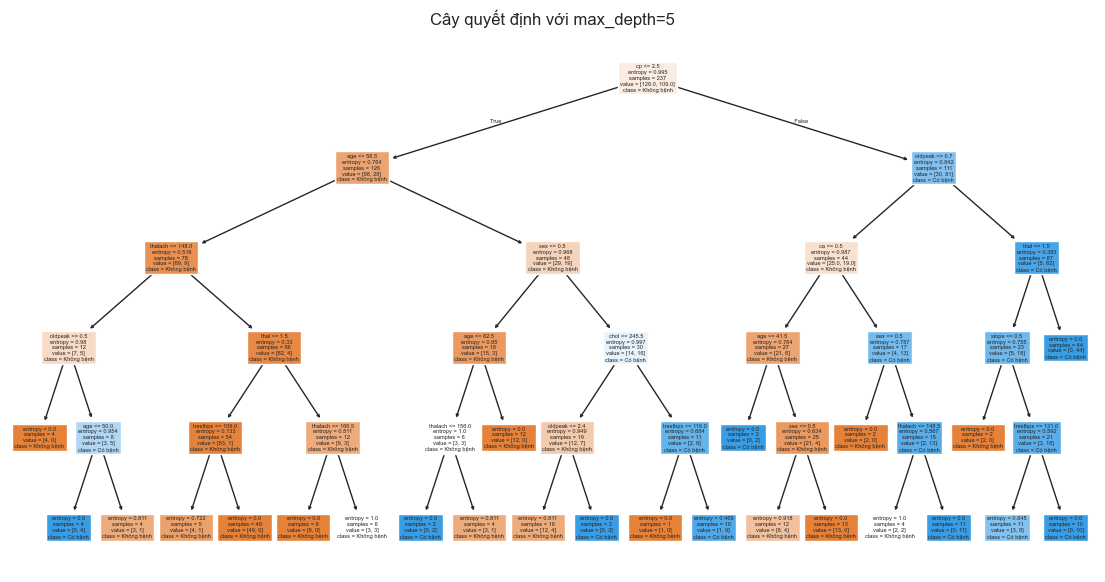

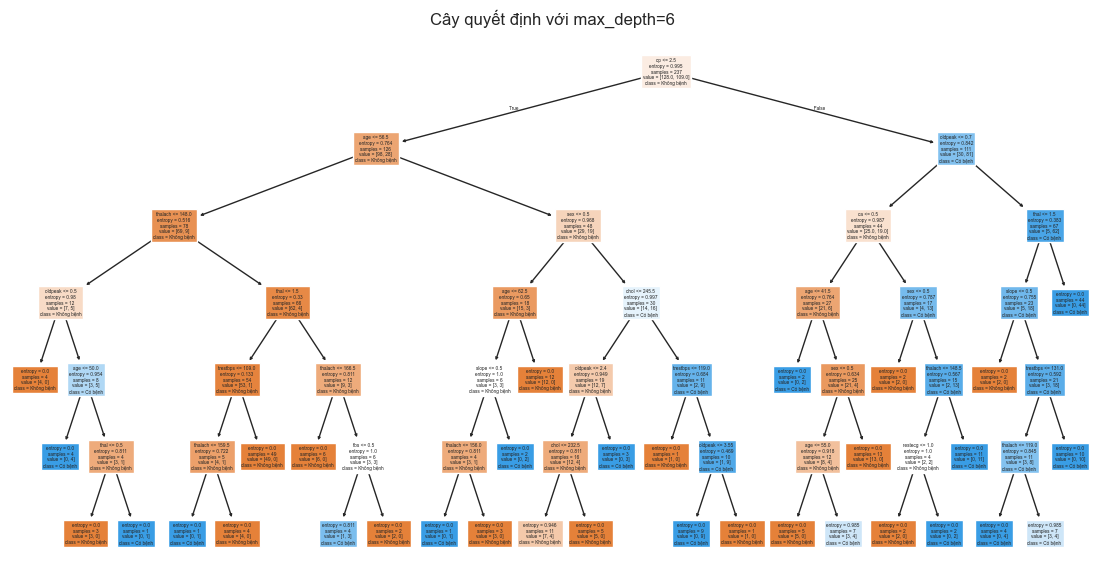

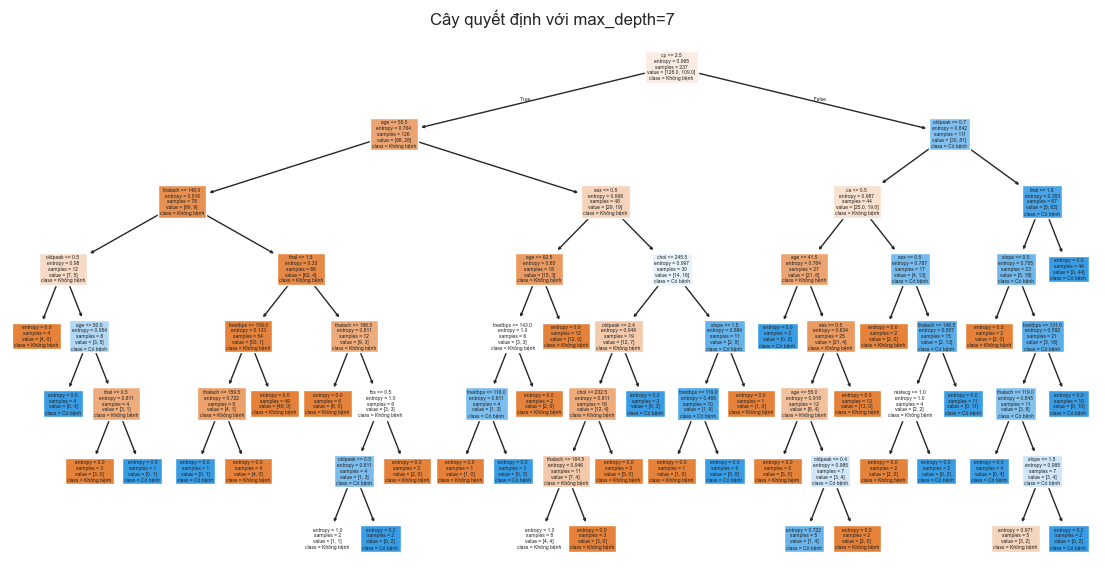

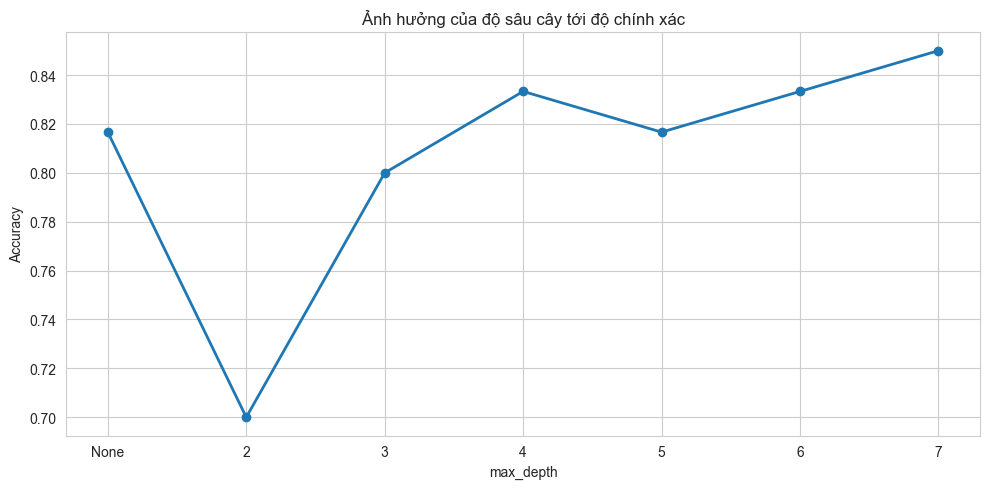

In [ ]:
# Dự án 2: Decision Tree - CS14003
# Nhóm: [Điền thông tin nhóm]
# Thành viên: [Điền thông tin thành viên]

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("=== DỰ ÁN DECISION TREE - CS14003 ===")

# ===== 1. ĐỌC DỮ LIỆU TỪ FILE data.csv =====
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]

df = pd.read_csv("../data/heart.csv", header=0)
print(df.columns)

df.replace("?", pd.NA, inplace=True)
df.dropna(inplace=True)
df = df.astype(float)
df["condition"] = df["condition"].apply(lambda x: 0 if x == 0 else 1)

X = df.drop("condition", axis=1)
y = df["condition"]

print(f"Tập dữ liệu có {X.shape[0]} mẫu và {X.shape[1]} đặc trưng.")
print(f"Phân phối nhãn:\n{y.value_counts()}")

# ===== 2.1. CHIA DỮ LIỆU THEO TỶ LỆ =====
split_ratios = [(0.4, 0.6), (0.6, 0.4), (0.8, 0.2), (0.9, 0.1)]
heart_splits = {}

for train_size, test_size in split_ratios:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, stratify=y, random_state=42
    )
    key = f'{int(train_size*100)}/{int(test_size*100)}'
    heart_splits[key] = {'X_train': X_train, 'X_test': X_test,
                         'y_train': y_train, 'y_test': y_test}

# Hàm vẽ phân bố nhãn
def plot_label_distribution(y_data, title):
    sns.countplot(x=y_data)
    plt.title(title)
    plt.xlabel("Nhãn")
    plt.ylabel("Số lượng")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

# Vẽ phân bố nhãn
for ratio, data in heart_splits.items():
    plot_label_distribution(data['y_train'], f"Phân bố nhãn - Train ({ratio})")
    plot_label_distribution(data['y_test'], f"Phân bố nhãn - Test ({ratio})")

# ===== 2.2. HUẤN LUYỆN MÔ HÌNH CHO CÁC TỶ LỆ =====
heart_models = {}
for ratio, data in heart_splits.items():
    clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    clf.fit(data['X_train'], data['y_train'])
    heart_models[ratio] = clf

    # Vẽ cây với độ sâu 3 cho dễ nhìn
    plt.figure(figsize=(15, 8))
    plot_tree(clf, feature_names=X.columns, class_names=["Không bệnh", "Có bệnh"],
              filled=True, max_depth=3)
    plt.title(f'Cây quyết định - Tỷ lệ {ratio}')
    plt.show()

# ===== 2.3. ĐÁNH GIÁ KẾT QUẢ =====
for ratio, data in heart_splits.items():
    clf = heart_models[ratio]
    y_pred = clf.predict(data['X_test'])

    print(f"\n=== KẾT QUẢ TỶ LỆ {ratio} ===")
    print("Classification Report:")
    print(classification_report(data['y_test'], y_pred, target_names=["Không bệnh", "Có bệnh"]))

    cm = confusion_matrix(data['y_test'], y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Không bệnh", "Có bệnh"],
                yticklabels=["Không bệnh", "Có bệnh"])
    plt.title(f'Confusion Matrix - {ratio}')
    plt.xlabel("Dự đoán")
    plt.ylabel("Thực tế")
    plt.tight_layout()
    plt.show()

# ===== 2.4. THỬ NGHIỆM max_depth TRÊN TỶ LỆ 80/20 =====
ratio_80_20 = heart_splits['80/20']
max_depths = [None, 2, 3, 4, 5, 6, 7]
depth_acc = []

for d in max_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42)
    clf.fit(ratio_80_20['X_train'], ratio_80_20['y_train'])
    y_pred = clf.predict(ratio_80_20['X_test'])
    acc = accuracy_score(ratio_80_20['y_test'], y_pred)
    depth_acc.append(acc)

    # Vẽ cây
    plt.figure(figsize=(14, 7))
    plot_tree(clf, feature_names=X.columns, class_names=["Không bệnh", "Có bệnh"], filled=True)
    plt.title(f'Cây quyết định với max_depth={d}')
    plt.show()

# Biểu đồ ảnh hưởng độ sâu
plt.figure(figsize=(10, 5))
plt.plot([str(d) for d in max_depths], depth_acc, marker='o', linewidth=2)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Ảnh hưởng của độ sâu cây tới độ chính xác")
plt.grid(True)
plt.tight_layout()
plt.show()
